# Load Data

In [1]:
#Cloud Object Storage setup    
#import ibm_boto3
#from ibm_botocore.client import Config
#import os
#import json
#import warnings
#import time

In [9]:
import numpy as np
import keras
from keras.layers import Activation, TimeDistributed, Dense, Input,RepeatVector, recurrent, Embedding, Dropout
from keras.layers.recurrent import LSTM,GRU
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.callbacks import Callback
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.utils import to_categorical

In [14]:
#By default, tensorflow pre-allocates nearly all of the available GPU memory, which is bad for a variety of use cases, 
#especially production and memory profiling.
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
#config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
#k.tensorflow_backend.set_session(tf.Session(config=config))
###################################
#Hopefully this might prevent ResourceExhaustedError that this sometimes throws.

In [5]:
X_train = pickle.load(open('X_train_small.pickle', 'rb'))

In [6]:
y_train = pickle.load(open('y_train_small.pickle', 'rb'))

In [7]:
X_train.shape

(200, 44)

In [8]:
y_train.shape

(200, 44)

In [8]:
X_train[0] #there are 200(original 221400) utterances and their correspoding responses.Each word has been converted to its corresponding index 
#(in accordance with (X/y)_word_to_idx.npy dictionaries)). The sequences has been padded with zeros to make all of them 150 words long
#'0' is actually the dictionary entry for EOL.The utterances have been reversed so as to avoid feeding 'zeroes' first to decoder network.

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 176, 473,   4,  37,
        55, 213, 455, 500, 327,  71, 155,  50, 282, 428,   7, 359, 277,
       475,  39,  92,  46, 186])

In [9]:
y_train[0]

array([191,   1,  58, 500, 110,  20, 500,  45,  44, 102,  20,   2,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0])

In [1]:
X_word_to_idx = np.load('X_word_to_idx_small.npy')
X_idx_to_word = np.load('X_idx_to_word_small.npy')
y_word_to_idx = np.load('y_word_to_idx_small.npy')
y_idx_to_word = np.load('y_idx_to_word_small.npy')
parameters    = np.load('parameters_small.npy')

In [7]:
for i, word in enumerate(X_idx_to_word[1:]):
    print(word)

you
to
i
the
a
of
and
that
me
like
is
he
your
for
not
do
i'm
she
know
out
my
just
what
in
but
with
you're
go
so
it
get
have
her
no
was
want
on
that's
this
don't
it's
be
how
if
got
we
think
night
going
are
one
why
then
people
up
always
can't
sister
did
never
because
at
bianca
him
he's
about
good
daddy
party
date
an
joey
thought
really
or
cameron
who
normal
prom
there
any
yeah
sure
girl
actually
school
talk
something
dating
they
when
make
unless
here
little
let
'
mind
thing
we're
hey
only
stuff
ask
means
didn't
even
where
tell
bogey
everyone
all
their
oh
part
crap
god
you'd
pretty
own
listen
does
had
what's
kat
doing
gigglepuss
okay
guys
need
look
mean
kidding
away
say
fan
completely
queen
fire
wanted
looked
head
kind
girls
great
sophomore
story
woman
high
until
tomorrow
heard
anything
same
having
hair
find
found
were
sit
belly
else
hot
might
haven't
couple
hate
before
will
as
she's
used
playing
though
patrick
again
won't
someone
guy
hates
his
told
supposed
could
gonna
can
plan
well
fren

In [10]:
X_vocab_size = len(X_word_to_idx.item())
y_vocab_size = len(y_word_to_idx.item())

In [10]:
X_vocab_size

501

In [11]:
y_vocab_size

501

In [12]:
print(parameters.item())

{'X_max_len': 44, 'MAX_LEN': 50, ' y_max_len': 44, 'VOCAB_SIZE': 500}


In [11]:
X_max_len =  parameters.item()['X_max_len']

In [12]:
y_max_len =  parameters.item()[' y_max_len']

In [16]:
print(X_max_len, y_max_len)

44 44


In [10]:
X_val = pickle.load(open('X_val.pickle', 'rb'))
y_val = pickle.load(open('y_val.pickle', 'rb'))

In [5]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history['acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [14]:
def show_generated_responses(input_utter, actual_response, generated_response, map_dict):
    for utter, actual, gener in zip(input_utter, actual_response, generated_response):
        print("Utterance :" + ' '.join([map_dict[int(i)] for i in utter if i > 0][::-1]) + "\n")
        print("Actual res:" + ' '.join([map_dict[int(i)] for i in actual if i > 0]) + "\n")
        print("genera res:" + ' '.join([map_dict[int(i)] for i in gener if i > 0]) + "\n")

In [161]:
#This implementation generates the dataset on multiple cores in real time and feed it right away to the deep learning model.
#Useful for Large datasets ref : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#Sequence are a safer way to do multiprocessing. 
#This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
#The method __getitem__ should return a complete batch
class BatchGenerator(keras.utils.Sequence):
    def __init__(self, X, y, X_max_len, y_max_len, batch_size, vocabulary, shuffle=True):
        'Initialization'
        self.X = X
        self.y = y
        self.X_max_len = X_max_len
        self.y_max_len = y_max_len
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        #print(int(np.ceil(len(self.X)/self.batch_size)))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.X)/self.batch_size))
    

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        #print("index ",index)
        #print("get item",indexes)
        # Generate data
        X_batch, y_batch = self.__data_generation(indexes)

        self.display_batch(X_batch,y_batch)

        return X_batch, y_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        # Initialization
        X_batch = np.zeros((self.batch_size, self.X_max_len))
        y_batch = np.zeros((self.batch_size, self.y_max_len, self.vocabulary))

        # Generate data
        for i, index in enumerate(indexes):
            # Utterance
            X_batch[i,:] = self.X[index]

            # Response
            y_batch[i,:,:] = to_categorical(self.y[index], num_classes=self.vocabulary)

        return X_batch, y_batch
    
    def display_batch(self, X_batch, y_batch):
        for U_sample,R_sample in zip(X_batch, y_batch):
            #print(U_sample)
            print("batch :")
            R_sample = np.argmax(R_sample, axis=1)
            print("U : "+' '.join([X_idx_to_word[int(i)] for i in U_sample if i > 0][::-1]))
            print("R : "+' '.join([y_idx_to_word[int(i)] for i in R_sample if i > 0]))     

In [11]:
tf.test.is_gpu_available()

True

# Encoder Decoder LSTM architecture 

In [3]:
#References -
#https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py
#https://colab.research.google.com/github/tensorflow/tensorflow/blob/r1.10/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb#scrollTo=s5hQWlbN3jGF
from keras.layers import  CuDNNGRU
from keras.layers import Bidirectional
import random
from keras.regularizers import l2
# seed weight initialization
random.seed(42)
np.random.seed(42)

def gru(units, regularizer, bidirectional, return_sequences):
  # If a GPU is available use CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        gru = CuDNNGRU(units, return_sequences=return_sequences, 
                                    kernel_regularizer=regularizer, 
                                    recurrent_regularizer=regularizer,
                                    bias_regularizer=regularizer,
                                    recurrent_initializer='glorot_uniform')
    else:
        gru = GRU(units, return_sequences=return_sequences, 
                                        kernel_regularizer=regularizer, 
                                        recurrent_regularizer=regularizer,
                                        bias_regularizer=regularizer,
                                        recurrent_initializer='glorot_uniform')
    if bidirectional:
        return Bidirectional(gru)
    return gru

def encoder_decoder(encoder_units,encoder_embed_dim,encoder_layers,
                         decoder_units,decoder_embed_dim,decoder_layers,
                         X_vocab_size,y_vocab_size,X_max_len, y_max_len,
                         learning_rate,optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],
                         clipvalue=0.5,weight_decay=None,bidirectional=False,pretrained_embed=None,dropout=0.5):
   
    model = Sequential()
    
    regularizer = l2(weight_decay) if weight_decay else None
    
    emb_weights = [pretrained_embed] if pretrained_embed else None
    
    ############   ENCODER   ##################
    #mask_zero s set to True because Masking is not supported for CuDNN RNNs.
    #For each timestep in the input tensor (dimension #1 in the tensor), 
    #if all values in the input tensor at that timestep are equal to mask_value, 
    #then the timestep will be masked (skipped) in all downstream layers (as long as they support masking).
    if tf.test.is_gpu_available(): 
        mask_zero = False
    else:
        mask_zero = True
    #The Embedding layer a trainable look-up table , it is initialized with random weights and will learn an embedding for all of the words in the training dataset.
    #creates a weight matrix of (vocabulary_size)x(embedding_dimension) dimensions
    #hidden-size is the size of the vector space in which words will be embedded. 
    #It defines the size of the output vectors from this layer for each word. 
    #hidden_size = the latent dimension

    model.add(Embedding(X_vocab_size, encoder_embed_dim, input_length=X_max_len,
                embeddings_regularizer=regularizer, weights=emb_weights, mask_zero=mask_zero,
                name='encoder_embedding'))

    if encoder_layers > 1: 
        for _ in range(1, encoder_layers):
            model.add(gru(encoder_units, regularizer, bidirectional, return_sequences=True))
            model.add(Dropout(dropout))
    model.add(gru(encoder_units, regularizer, bidirectional, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(RepeatVector(y_max_len))
    
    ############   DECODER   ##################
 
    for _ in range(1, decoder_layers+1):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
        model.add(gru(decoder_units, regularizer, bidirectional, return_sequences=True))
        model.add(Dropout(dropout))

    # Apply a dense layer to the every temporal slice of an input. For each of step
    # of the output sequence, decide which character should be chosen.
    model.add(TimeDistributed(Dense(y_vocab_size, activation='softmax') ))
    
    #############################################
    if optimizer == 'adam':
        opt = Adam(lr=learning_rate, clipvalue=clipvalue)
    elif optimizer == 'rmsprop':
        opt = RMSprop(lr=learning_rate, clipvalue=clipvalue)
    
    model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)
    return model

# Baseline encoder decoder LSTM architecture trained with Cornell Movie Database alone

In [168]:
#Baseline Model parameters
learning_rate = 0.001
encoder_units = 100
encoder_embed_dim = 100
encoder_layers = 2
decoder_units = 100
decoder_embed_dim = 0
decoder_layers =3 
batch_size = 4
num_epochs = 10 

model = encoder_decoder(encoder_units,encoder_embed_dim,encoder_layers,
                         decoder_units,decoder_embed_dim,decoder_layers,
                         X_vocab_size,y_vocab_size,X_max_len, y_max_len,learning_rate)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_embedding (Embedding (None, 44, 100)           50100     
_________________________________________________________________
cu_dnngru_19 (CuDNNGRU)      (None, 44, 100)           60600     
_________________________________________________________________
dropout_19 (Dropout)         (None, 44, 100)           0         
_________________________________________________________________
cu_dnngru_20 (CuDNNGRU)      (None, 100)               60600     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 44, 100)           0         
_________________________________________________________________
cu_dnngru_21 (CuDNNGRU)      (None, 44, 100)           60600     
__________

In [31]:
for layer in model.layers:
    print("layer :",layer.get_config()['name'])
    try:
        print("Input : " + str(layer.get_input_at(0).get_shape().as_list()))
    except:
        print("Input : " + str(layer.get_input_at(0)))
    try:
        print("Output : " + str(layer.get_output_at(0).get_shape().as_list()))
    except:
        print("Output : " + str(layer.get_output_at(0)))
    try:
        if layer.get_config()['trainable']:
            print("Weights : " + str(layer.get_weights()[0].shape))
    except:
        print("not trainable")

layer : encoder_embedding
Input : [None, 44]
Output : [None, 44, 100]
Weights : (501, 100)
layer : cu_dnngru_4
Input : [None, 44, 100]
Output : [None, 44, 100]
Weights : (100, 300)
layer : dropout_4
Input : [None, 44, 100]
Output : [None, 44, 100]
not trainable
layer : cu_dnngru_5
Input : [None, 44, 100]
Output : [None, 100]
Weights : (100, 300)
layer : dropout_5
Input : [None, 100]
Output : [None, 100]
not trainable
layer : repeat_vector_3
Input : [None, 100]
Output : [None, 44, 100]
not trainable
layer : cu_dnngru_6
Input : [None, 44, 100]
Output : [None, 44, 100]
Weights : (100, 300)
layer : dropout_6
Input : [None, 44, 100]
Output : [None, 44, 100]
not trainable
layer : cu_dnngru_7
Input : [None, 44, 100]
Output : [None, 44, 100]
Weights : (100, 300)
layer : dropout_7
Input : [None, 44, 100]
Output : [None, 44, 100]
not trainable
layer : cu_dnngru_8
Input : [None, 44, 100]
Output : [None, 44, 100]
Weights : (100, 300)
layer : dropout_8
Input : [None, 44, 100]
Output : [None, 44, 10

In [91]:
X_train[:10,]

array([[    0,     0,     0, ...,   109,    22,    50],
       [    0,     0,     0, ...,   142,     2,    57],
       [    0,     0,     0, ..., 10158,     3,    26],
       ...,
       [    0,     0,     0, ...,     0,     0,    60],
       [    0,     0,     0, ...,    64,  2850,  9219],
       [    0,     0,     0, ...,   128,    42,  2234]])

In [102]:
X_train[:10,].shape

(10, 150)

In [165]:
train_data_generator = BatchGenerator(X_train, y_train, X_max_len, y_max_len, batch_size, y_vocab_size)

In [169]:
#Multiprocessing=True will not work on Windows
#Since Windows has no fork, the multiprocessing module starts a new Python process and imports the calling module.
#Without __name__ == __main__ idiom the new process 
#(started by keras' fit_generator()) will call your all code again and will start another process, 
#and so on ad infinitum (until OOM).
model.fit_generator(generator=train_data_generator,epochs=num_epochs,
                    use_multiprocessing=False)

Epoch 1/10
batch :
U : you set me up
R : i just wanted
batch :
U : i just wanted
R : what to completely damage me to UNK me to UNK forever what
batch :
U : what to completely damage me to UNK me to therapy forever what
R : no i just wanted
batch :
U : is that woman a complete fruit loop or is it just me
R : it's just you
batch :
U : i wanted to let you make up your own mind about him
R : no you didn't if you really thought i could make my own decisions you would've let me go out with him instead of helping daddy hold me hostage
batch :
U : that's not
R : i'm not stupid enough to repeat your mistakes
batch :
U : i'm not stupid enough to repeat your mistakes
R : i guess i thought i was UNK you
batch :
U : i guess i thought i was protecting you
R : god you're just like him just UNK me locked away in the UNK so i can't experience anything for myself
batch :
U : i don't get you you act like you're too good for any of this and then you go totally apeshit when you get here
R : you're UNK
batc

 9/50 [====>.........................] - ETA: 30s - loss: 5.8604 - acc: 0.6780batch :
U : UNK one she hates UNK
R : it's a lung UNK UNK
batch :
U : it's a lung cancer UNK
R : her favorite UNK
batch :
U : her favorite uncle
R : dead at forty one
batch :
U : he's pretty
R : okay i wasn't sure
batch :
U : like i'm supposed to know what that even means
R : it's shakespeare maybe you've heard of him
batch :
U : it's shakespeare maybe you've heard of him
R : yeah he's your freak friend mandella's boyfriend i guess since i'm not allowed to go out i should UNK over a dead guy too
batch :
U : you are so completely unbalanced
R : can we go now
batch :
U : bianca i need to talk to you i need to tell you
R : i really don't think i need any social UNK from you right now
11/50 [=====>........................] - ETA: 24s - loss: 5.6320 - acc: 0.6761batch :
U : you the new guy
R : so they tell me
batch :
U : so they tell me
R : UNK i'm supposed to give you the tour
batch :
U : so which dakota you from

30/50 [=================>............] - ETA: 4s - loss: 3.2760 - acc: 0.7604batch :
U : i was kidding people actually live there
R : yeah a couple we're UNK UNK the UNK though
batch :
U : yeah a couple we're outnumbered by the cows though
R : how many people were in your UNK school
batch :
U : how many people were in your old school
R : thirty two
batch :
U : thirty two
R : get out
batch :
U : hi
R : UNK like things worked out tonight huh
batch :
U : you know chastity
R : i UNK we UNK an UNK UNK
batch :
U : have fun tonight
R : tons
batch :
U : i looked for you back at the party but you always seemed to be occupied
R : i was
batch :
U : then guillermo says if you go any lighter you're gonna look like an extra on UNK
R : no
batch :
U : do you listen to this crap
R : what crap
batch :
U : what crap
R : me this UNK blonde babble i'm like boring myself
batch :
U : me this UNK blonde babble i'm like boring myself
R : UNK god if i had to UNK one more story about your coiffure
33/50 [=======

 1/50 [..............................] - ETA: 5s - loss: 2.6617 - acc: 0.5966batch :
U : but you hate joey
R : now i do back then was a different story
batch :
U : no kidding he's a criminal i heard he UNK a state trooper on fire he just got out of alcatraz
R : they always let felons sit in on honors biology
batch :
U : sure do my mom's from canada
R : guess who just UNK up for a tutor
batch :
U : you looked UNK last night you know
R : so did you
batch :
U : listen i want to talk to you about the prom
R : you know the deal i can ' t go if kat doesn't go
batch :
U : didn't have you pegged for a gigglepuss fan aren't they a little too pre UNK belly UNK ring for you
R : fan of a fan you see a couple of minors UNK in
batch :
U : he UNK everyone was doing it so i did it
R : you did what
batch :
U : UNK one she hates UNK
R : it's a lung UNK UNK
 3/50 [>.............................] - ETA: 2s - loss: 1.8514 - acc: 0.7367batch :
U : that's not
R : i'm not stupid enough to repeat your mistakes

U : there
R : where
batch :
U : hey do you mind
R : not at all
batch :
U : you know chastity
R : i UNK we UNK an UNK UNK
batch :
U : she UNK me
R : where
21/50 [===========>..................] - ETA: 0s - loss: 1.5394 - acc: 0.7863batch :
U : and where're you going
R : if you UNK know we were attempting to go to a small study group of friends
batch :
U : how many people were in your old school
R : thirty two
batch :
U : forget his UNK do you think UNK got a plan or not
R : did she actually say she'd go out with you
batch :
U : after that i UNK i'd never do anything just because everyone else was doing it and i haven't UNK except for UNK party and my stunning gastro intestinal UNK
R : why didn't you tell me
batch :
U : promise me you won't talk to any boys unless your sister is present
R : why
batch :
U : no
R : you might wanna think about it
batch :
U : you got something on your mind
R : i counted on you to UNK my cause you and that thug are obviously UNK aren't we ever going on UNK da

 1/50 [..............................] - ETA: 3s - loss: 1.9176 - acc: 0.7273batch :
U : oh my god does this mean you're UNK normal
R : it means that gigglepuss is playing at club skunk and we're going
batch :
U : lesbian no i found a picture of jared UNK in one of her UNK so i'm pretty sure she's not harboring same sex tendencies
R : so that's the kind of guy she UNK pretty ones
batch :
U : where did he go he was just here
R : who
batch :
U : after that i UNK i'd never do anything just because everyone else was doing it and i haven't UNK except for UNK party and my stunning gastro intestinal UNK
R : why didn't you tell me
batch :
U : what
R : in 9th for a month
batch :
U : the real you
R : like my fear of wearing pastels
batch :
U : always a UNK UNK
R : didn't have you pegged for a gigglepuss fan aren't they a little too pre teen belly UNK UNK for you
batch :
U : i thought you hated UNK people
R : hey i've UNK have a few clients when i get to wall street
batch :
U : listen i know you 

batch :
U : how do you get your hair to look like that
R : UNK deep conditioner UNK two days and i never ever UNK a UNK without the diffuser attachment
batch :
U : this is it a golden opportunity patrick can ask katarina to the party
R : in that case we'll need to make it a school UNK blow out
batch :
U : hey sweet cheeks
R : hi joey
batch :
U : what do you think
R : i think you're a freak i think you do this to UNK me and i think you UNK
22/50 [============>.................] - ETA: 0s - loss: 1.5111 - acc: 0.7885batch :
U : can't you forget for just one night that you're completely UNK
R : at least i'm not a clouted fen sucked UNK pig
batch :
U : hey do you mind
R : not at all
batch :
U : it's shakespeare maybe you've heard of him
R : yeah he's your freak friend mandella's boyfriend i guess since i'm not allowed to go out i should UNK over a dead guy too
batch :
U : you mean i'd get a chance to talk to her
R : you could UNK with her my friend
batch :
U : sure
R : then go get her
batc

batch :
U : but
R : you always been this selfish
batch :
U : i'm serious UNK he's whacked he sold his own liver on the UNK market so he could buy new UNK
R : forget his UNK do you think we've got a plan or not
batch :
U : who
R : joey
batch :
U : oh god it's starting
R : it's just a party daddy
batch :
U : c'esc ma tete this is my head
R : right see you're ready for the quiz
batch :
U : you're ruining my life' because you won't be normal i can't be normal
R : what's normal
batch :
U : how is UNK little find the UNK a date plan progressing
R : well there's someone i think might be
batch :
U : never
R : padua girls one tall UNK body the other one UNK short and undersexed
batch :
U : okay likes UNK food feminist prose and angry stinky girl UNK of the indie rock persuasion
R : so what does that give me i'm supposed to buy her some UNK and a book and sit UNK listening to UNK who can't play their UNK
batch :
U : but you hate joey
R : now i do back then was a different story
batch :
U : extre

12/50 [======>.......................] - ETA: 1s - loss: 1.5273 - acc: 0.7836batch :
U : this is it a golden opportunity patrick can ask katarina to the party
R : in that case we'll need to make it a school UNK blow out
batch :
U : what to completely damage me to UNK me to therapy forever what
R : no i just wanted
batch :
U : if you UNK know we were attempting to go to a small study group of friends
R : UNK known as an orgy
batch :
U : what
R : in 9th for a month
batch :
U : what good stuff
R : the real you
batch :
U : will bogey get bent
R : are you kidding he'll UNK himself with joy he's the UNK UNK ass
batch :
U : daddy no
R : just for a UNK
batch :
U : why do girls like that always like guys like that
R : because they're UNK to their mothers liked guys like that and their grandmothers before them their UNK pool is UNK UNK
batch :
U : yeah just a minor encounter with the shrew
R : that's her bianca's sister
batch :
U : i don't get you you act like you're too good for any of this and

30/50 [=================>............] - ETA: 0s - loss: 1.3841 - acc: 0.8061batch :
U : hey sweet cheeks
R : hi joey
batch :
U : daddy i
R : and where're you going
batch :
U : that's her bianca's sister
R : the mewling rampalian wretch UNK
batch :
U : how do you get your hair to look like that
R : UNK deep conditioner UNK two days and i never ever UNK a UNK without the diffuser attachment
batch :
U : guess who just UNK up for a tutor
R : you UNK i'd get a chance to UNK to her
batch :
U : bianca i need to talk to you i need to tell you
R : i really don't think i need any social UNK from you right now
batch :
U : what's the UNK
R : you get the girl
batch :
U : i wanted to let you make up your own mind about him
R : no you didn't if you really thought i could make my own decisions you would've let me go out with him instead of helping daddy hold me hostage
32/50 [==================>...........] - ETA: 0s - loss: 1.3850 - acc: 0.8059batch :
U : UNK
R : let's go
batch :
U : like you care
R

 1/50 [..............................] - ETA: 6s - loss: 2.0653 - acc: 0.6932batch :
U : he practically proposed when he found out we had the same UNK i mean dr bonchowski is great an all but he's not exactly relevant party UNK
R : is he oily or dry
batch :
U : never
R : padua girls one tall UNK body the other one UNK short and undersexed
batch :
U : UNK you do to her
R : i don ' t know i decided not to UNK her when she was too drunk to remember it
batch :
U : why
R : because she'll scare them away
batch :
U : get out
R : how many people go here
batch :
U : that's her bianca's sister
R : the mewling rampalian wretch UNK
batch :
U : he seems like he thrives on danger
R : no kidding he's a UNK i heard he UNK a state UNK on fire he just got out of alcatraz
batch :
U : you burn you pine you perish
R : who is she
batch :
U : neat
R : my UNK says i've got a good shot at being the UNK guy next year
batch :
U : north actually how'd you
R : i was kidding people actually UNK there
batch :
U : bu

batch :
U : he UNK everyone was doing it so i did it
R : you did what
batch :
U : how many people were in your old school
R : thirty two
batch :
U : let go
R : you UNK me up
batch :
U : unsolved mystery she used to be really UNK when she UNK high school then it was just like she got UNK of it or something
R : that's a shame
22/50 [============>.................] - ETA: 0s - loss: 1.4758 - acc: 0.7893batch :
U : not the hacking and UNK and spitting part UNK
R : okay then how 'bout we UNK out some french UNK saturday night
batch :
U : daddy no
R : just for a UNK
batch :
U : i have to be home in twenty minutes
R : i don't have to be UNK UNK two
batch :
U : wear the belly before you go
R : daddy no
batch :
U : you told me that part already
R : hell i've just been going over the whole thing in my head and
batch :
U : i do care but i'm a firm UNK in doing something for your own UNK not someone else ' s
R : i wish i had that UNK i'm the only sophomore that got asked to the prom and i can't go

 1/50 [..............................] - ETA: 3s - loss: 1.2024 - acc: 0.8125batch :
U : then guillermo says if you go any lighter you're gonna look like an extra on UNK
R : no
batch :
U : daddy i want to discuss the prom with you it's tomorrow night
R : the prom kat has a date
batch :
U : this is it a golden opportunity patrick can ask katarina to the party
R : in that case we'll need to make it a school UNK blow out
batch :
U : queen harry
R : it's a gay cruise line but i'll be like wearing a uniform and stuff
batch :
U : the thing is cameron i'm at the UNK of a UNK hideous breed of UNK my sister i can't date until she does
R : seems like she could get a date easy enough
batch :
U : daddy people expect me to be there
R : if kat's not going you're not going
batch :
U : it's more
R : UNK
batch :
U : cameron i'm a little busy
R : it's off the whole thing
batch :
U : where've you been
R : nowhere hi daddy
batch :
U : you know chastity
R : i UNK we UNK an UNK UNK
batch :
U : cameron
R : t

20/50 [===========>..................] - ETA: 0s - loss: 1.5810 - acc: 0.7753batch :
U : but
R : you always been this selfish
batch :
U : joey never told you we went out did he
R : what
batch :
U : you UNK the woman UNK yourself on the altar of dignity and even the score
R : best case scenario you're back on the UNK for UNK
batch :
U : what's normal
R : bogey lowenstein's party is normal but you're too busy listening to UNK who need prozac to know that
batch :
U : wear the belly before you go
R : daddy no
batch :
U : it's a lung cancer UNK
R : her favorite UNK
batch :
U : you the new guy
R : so they tell me
batch :
U : away
R : your sister here
22/50 [============>.................] - ETA: 0s - loss: 1.5996 - acc: 0.7717batch :
U : he UNK everyone was doing it so i did it
R : you did what
batch :
U : will bogey get bent
R : are you kidding he'll UNK himself with joy he's the UNK UNK ass
batch :
U : her favorite uncle
R : dead at forty one
batch :
U : well i thought we'd start with UNK 

 1/50 [..............................] - ETA: 5s - loss: 1.6254 - acc: 0.7784batch :
U : he UNK everyone was doing it so i did it
R : you did what
batch :
U : i don't want to know how to say that though i want to know useful UNK like where the good stores are how UNK does champagne cost stuff like chat i have never in my life had to point out my head to someone
R : that's because it's such a nice one
batch :
U : that i'm used to
R : yeah but these guys have never UNK a UNK they just jack off to clint eastwood
batch :
U : he always have that shit eating UNK
R : joey dorsey UNK shit grin i wish i could say he's a UNK but he's UNK twelve in the class and a UNK mostly UNK stuff but he's UNK to have a big UNK sock UNK coming out
batch :
U : UNK known as an UNK
R : it's just a party daddy but i UNK you'd forbid me to go since gloria steinem over there UNK going
batch :
U : forget his UNK do you think UNK got a plan or not
R : did she actually say she'd go out with you
batch :
U : they do to


19/50 [==========>...................] - ETA: 0s - loss: 1.5855 - acc: 0.7760batch :
U : daddy i
R : and where're you going
batch :
U : what makes you think he'll do it
R : he seems like he UNK on danger
batch :
U : cameron i'm a little busy
R : it's off the whole thing
batch :
U : thirty two
R : get out
batch :
U : did you change your hair
R : no
batch :
U : you burn you pine you perish
R : who is she
batch :
U : like you care
R : i do care but i'm a firm UNK in doing something for your own UNK not someone else ' s
batch :
U : well no
R : then that's all you had to say
batch :
U : then that's all you had to say
R : but
batch :
U : why didn't you tell me
R : i wanted to let you make up your own mind about him
batch :
U : now don't get upset daddy but there's this boy and i think he might ask
R : no you're not dating until your sister starts dating end of discussion
batch :
U : i'm UNK something
R : i have a date daddy and he ' s not a captain of oppression like some UNK we know
22/50 [

 1/50 [..............................] - ETA: 3s - loss: 0.5956 - acc: 0.9205batch :
U : get out
R : how many people go here
batch :
U : he's pretty
R : okay i wasn't sure
batch :
U : right see you're ready for the quiz
R : i don't want to know how to say that though i want to know useful things like where the good stores are how UNK does UNK cost stuff like UNK i have never in my life had to point out my head to someone
batch :
U : sure do my mom's from canada
R : guess who just UNK up for a tutor
batch :
U : well no
R : then that's all you had to say
batch :
U : god you're just like him just UNK me UNK away in the dark so i can't experience anything for myself
R : not all UNK are good bianca you can't always trust the people you want to
batch :
U : can't you forget for just one night that you're completely UNK
R : at least i'm not a clouted fen sucked UNK pig
batch :
U : what good stuff
R : the real you
batch :
U : they always let felons sit in on honors biology
R : i'm serious man h

50/50 [==============================] - 1s 24ms/step - loss: 1.4556 - acc: 0.7932
Epoch 9/10
batch :
U : he practically proposed when he found out we had the same UNK i mean dr bonchowski is great an all but he's not exactly relevant party UNK
R : is he oily or dry
batch :
U : what crap
R : me this UNK blonde babble i'm like boring myself
batch :
U : now don't get upset daddy but there's this boy and i think he might ask
R : no you're not dating until your sister starts dating end of discussion
batch :
U : you mean i'd get a chance to talk to her
R : you could UNK with her my friend
batch :
U : that girl i
R : you burn you pine you perish
batch :
U : it's a lung cancer UNK
R : her favorite UNK
batch :
U : fan of a fan you see a couple of minors UNK in
R : never
batch :
U : that's not
R : i'm not stupid enough to repeat your mistakes
batch :
U : you got him involved
R : like we had a choice besides when you let the UNK think he's UNK the UNK you're in a position of power we let him pre

batch :
U : thirty two
R : get out
batch :
U : he UNK everyone was doing it so i did it
R : you did what
batch :
U : you told me that part already
R : hell i've just been going over the whole thing in my head and
batch :
U : great
R : would you mind UNK me a drink cameron
 9/50 [====>.........................] - ETA: 1s - loss: 1.3913 - acc: 0.7999batch :
U : listen i know you hate having to sit home because i'm not susie high school
R : like you care
batch :
U : she okay
R : i UNK so
batch :
U : what 're you talking about
R : she's UNK to joey not me
batch :
U : no
R : okay you're gonna need to learn how to UNK
batch :
U : you are so completely unbalanced
R : can we go now
batch :
U : will bogey get bent
R : are you kidding he'll UNK himself with joy he's the UNK UNK ass
batch :
U : i was kidding people actually live there
R : yeah a couple we're UNK UNK the UNK though
batch :
U : in that case we'll need to make it a school UNK blow out
R : will bogey get bent
11/50 [=====>...........

batch :
U : who is she
R : bianca stratford sophomore don't even think about it
batch :
U : oh i thought you might have a date i don't know why i'm UNK to ask but are you going to bogey UNK party saturday night
R : what do you think
batch :
U : he's pretty
R : okay i wasn't sure
batch :
U : why
R : because she'll scare them away
29/50 [================>.............] - ETA: 0s - loss: 1.4979 - acc: 0.7841batch :
U : gosh if only we could find kat a boyfriend
R : let me see what i can do
batch :
U : daddy i want to discuss the prom with you it's tomorrow night
R : the prom kat has a date
batch :
U : yeah and i UNK the only part of you featured in your big kmart spread was your UNK tough break
R : they're running the rest of me next month
batch :
U : hi joey
R : you're concentrating awfully UNK considering it's gym class
batch :
U : so yeah i've got the UNK catalog thing going and the UNK sock gig that's gonna be huge and then i'm up for an ad for queen harry next week
R : queen UNK
batc

 1/50 [..............................] - ETA: 6s - loss: 0.7131 - acc: 0.8920batch :
U : you know if you do go out with bianca you'd be set you'd outrank everyone strictly a list with me by your UNK
R : i thought you hated UNK people
batch :
U : but
R : after that i UNK i'd never do anything just because everyone else was doing it and i haven't since except for UNK party and my stunning gastro UNK UNK
batch :
U : UNK known as an UNK
R : it's just a party daddy but i UNK you'd forbid me to go since gloria steinem over there UNK going
batch :
U : great
R : would you mind UNK me a drink cameron
batch :
U : sure do my mom's from canada
R : guess who just UNK up for a tutor
batch :
U : patrick is that a
R : perm
batch :
U : no you're not dating until your sister starts dating end of discussion
R : what if she never starts dating
batch :
U : hey do you mind
R : not at all
 3/50 [>.............................] - ETA: 2s - loss: 1.0581 - acc: 0.8352batch :
U : is that woman a complete fruit l

batch :
U : gigglepuss is playing there tomorrow night
R : don't make me do it man
batch :
U : not the hacking and UNK and spitting part UNK
R : okay then how 'bout we UNK out some french UNK saturday night
batch :
U : what's normal
R : bogey lowenstein's party is normal but you're too busy listening to UNK who need prozac to know that
batch :
U : they always let felons sit in on honors biology
R : i'm serious man he's whacked he UNK his own liver on the UNK market so he could buy new UNK
20/50 [===========>..................] - ETA: 0s - loss: 1.4139 - acc: 0.7918batch :
U : fan of a fan you see a couple of minors UNK in
R : never
batch :
U : but
R : you always been this selfish
batch :
U : oh god it's starting
R : it's just a party daddy
batch :
U : you are so completely unbalanced
R : can we go now
batch :
U : where did he go he was just here
R : who
batch :
U : i really really really UNK go but i can't not unless my sister goes
R : i'm UNK on it but she doesn't UNK to be goin' for 

50/50 [==============================] - 1s 25ms/step - loss: 1.4438 - acc: 0.7932


In [116]:
#prediction
test_data = ['Hi', 'How are you?', 'What is your name?', 'I like you.', 'You act stupid', 'why']
from keras.preprocessing.text import text_to_word_sequence
#Tokenize
def tokenize(X, max_len, reverse=False):
    '''
    X : sentences, separated by '/n'
    max_len : maximum number of words allowed in sentences after which they will be truncated
    reverse : reverse the order of words in X
    '''
    #X = X.split('\n')

    if reverse: 
        #X = [text_to_word_sequence(x)[::-1] for x in X if len(x.split()) > 0 and len(x.split()) <= max_len]
        X = [text_to_word_sequence(x)[::-1] for x in X ]
        
    else: 
        X = [text_to_word_sequence(x) for x in X ]
        #X = [text_to_word_sequence(x) for x in X if len(x.split()) > 0 and len(x.split()) <= max_len]
    return X
X = tokenize(test_data, X_max_len, reverse=True)

In [117]:
X

[['hi'],
 ['you', 'are', 'how'],
 ['name', 'your', 'is', 'what'],
 ['you', 'like', 'i'],
 ['stupid', 'act', 'you'],
 ['why']]

In [118]:
X_word_to_idx.item()['why']

52

In [119]:
from keras.preprocessing.sequence import pad_sequences
def convert_to_numbers(X, word_to_idx, pad=True,  padding='pre'):
    '''
    We need to convert words to numbers(i.e their corresponding indices) coz computers understand only numbers. 
    steps:
    1) Convert each word in the sentence to its index value
    2) If 'pad = True' ,pad zeros into our sequences, so as all the sequences will have a same length(this is an alternative to bucketing)
  
    '''
    #Convert each word in the sentence to its index value
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in word_to_idx:
                X[i][j] = word_to_idx[word]
            else:
                X[i][j] = word_to_idx['UNK']
    #X_max_len = max([len(sentence) for sentence in X])

    X = pad_sequences(X, maxlen=X_max_len, dtype='int32', padding=padding)
    return X

In [120]:
X = convert_to_numbers(X, X_word_to_idx.item(), pad=True, padding='pre')

In [136]:
prediction = model.predict(X_train)  

In [137]:
prediction.shape

(200, 44, 501)

In [142]:
np.argmax(prediction,axis=2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [143]:
np.argmax(prediction[0][20])

0

so far the model is showing no talent, it predicts spaces for everything.But we trained only on 200 lines, it is terribly underfitting.

The baseline model was trained on IBM Watson Studio environment (K-80 GPU) with the entire train data with batch size 16 and Epochs=1 (I made an attempt to increase the number of Epochs to 10 ..but it was taking a lot of time).
but the training never got beyond - 

     training-thI_bHLig: 9589/13838 [===================>..........] - ETA: 1:33:37 - loss: 0.6424 - acc: 0.9302 
     
This may be due to exploding/vanishing gradients(I may have to monitor this)
Trying gradient clipping and regularization with small alpha.
https://machinelearningmastery.com/exploding-gradients-in-neural-networks/

In [15]:
#Baseline Model parameters
learning_rate = 0.001
encoder_units = 100
encoder_embed_dim = 100
encoder_layers = 2
decoder_units = 100
decoder_embed_dim = 0
decoder_layers =3 
batch_size = 4
num_epochs = 10 

model = encoder_decoder(encoder_units,encoder_embed_dim,encoder_layers,
                         decoder_units,decoder_embed_dim,decoder_layers,
                         X_vocab_size,y_vocab_size,X_max_len, y_max_len,learning_rate,bidirectional=True,clipvalue=0.5,weight_decay=0.000001)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_embedding (Embedding (None, 44, 100)           50100     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 44, 200)           121200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               181200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 44, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 44, 200)           181200    
__________

In [147]:
train_data_generator = BatchGenerator(X_train, y_train, X_max_len, y_max_len, batch_size, y_vocab_size)

In [148]:
model.fit_generator(generator=train_data_generator,epochs=num_epochs,
                    use_multiprocessing=False)

Epoch 1/10
50/50 [==============================] - 17s 339ms/step - loss: 2.6388 - acc: 0.7680
Epoch 2/10
50/50 [==============================] - 1s 24ms/step - loss: 1.5052 - acc: 0.7932
Epoch 3/10
50/50 [==============================] - 1s 24ms/step - loss: 1.4810 - acc: 0.7932
Epoch 4/10
50/50 [==============================] - 1s 24ms/step - loss: 1.4713 - acc: 0.7932
Epoch 5/10
50/50 [==============================] - 1s 25ms/step - loss: 1.4688 - acc: 0.7932
Epoch 6/10
50/50 [==============================] - 1s 25ms/step - loss: 1.4591 - acc: 0.7932
Epoch 7/10
50/50 [==============================] - 1s 25ms/step - loss: 1.4547 - acc: 0.7932
Epoch 8/10
50/50 [==============================] - 1s 24ms/step - loss: 1.4572 - acc: 0.7932
Epoch 9/10
50/50 [==============================] - 1s 24ms/step - loss: 1.4475 - acc: 0.7932
Epoch 10/10
50/50 [==============================] - 1s 24ms/step - loss: 1.4455 - acc: 0.7932


The baseline model trained in the IBM Watson Studio environment (K-80 GPU) with the entire train data(Cornell Movie dataset) with batch size 32 and Epochs=1, with regularisation and gradient clipping(this things helped to make training stable).

    6919/6919 [==============================] - 17185s 2s/step - loss: 0.6560 - acc: 0.9300
 

In [177]:
from keras.models import load_model
import json
model = load_model('baseline.h5')

In [172]:
predictions = np.argmax(model.predict(X_val), axis=2) ##Greedy Search Decoder

In [154]:
X_val.shape

(25, 150)

In [153]:
predictions.shape

(25, 150)

In [12]:
y_idx_to_word_full = np.load('y_idx_to_word.npy')

In [158]:
show_generated_responses(X_val, y_val, predictions, y_idx_to_word_full)

Utterance :as in

Actual res:his schwanzstucker

genera res:i

Utterance :as depp

Actual res:whew a nineteen inch drill

genera res:i

Utterance :but working going actually you use smythe

Actual res:do you know the theme from 'doctor zhivago'

genera res:i

Utterance :do wrong movie

Actual res:why don't we all turn in it's been a long day

genera res:i

Utterance :take that's each 'em come

Actual res:you can't expect to iron out all the kinks in one night

genera res:i

Utterance :you tell air to competition out are the julie'll me right better

Actual res:i think the doctor is a genius don't you igor

genera res:i

Utterance :i think the actually is a tests for you prescott

Actual res:why certainly don't you frau blucher

genera res:i

Utterance :that's i'm you this into girl

Actual res:the doctor said to allow seven minutes no more and no less or else they could both become hopelessly paralyzed

genera res:i

Utterance :that's doing is it you're each

Actual res:four

genera re

In [ ]:
The Utterances are appearing weird because I used 

In [159]:
predictions

array([[2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [178]:
prediction = model.predict(X_val)

In [181]:
prediction[0].shape

(150, 47973)

In [182]:
np.argsort(prediction[0], axis=1)

array([[47961, 43834, 44317, ...,    20,     1,     2],
       [36647, 43835, 33866, ...,     2,     1,     0],
       [32475, 34244, 33866, ...,     2,     1,     0],
       ...,
       [ 8040,  1496, 28567, ...,     7,     3,     0],
       [ 8040,  1496, 28567, ...,     7,     3,     0],
       [ 8040,  1496, 28567, ...,     7,     3,     0]], dtype=int64)

In [184]:
y_idx_to_word_full[2]

'i'

In [185]:
y_idx_to_word_full[1]

'you'

In [186]:
y_idx_to_word_full[20]

'no'

In [187]:
y_idx_to_word_full[3]

'the'

In [188]:
y_idx_to_word_full[7]

'and'

Terrible underfitting! It is predicting most frequently used words..Training for just 1 epoch did not help it "learn" anything..we need to sprinkle more fairy dust..

     I need to train it longer.
     
***********************************************************************
     

Trained longer for 10 epochs using Bidirectional GRUs.

In [2]:
history = {'acc': [0.9296807104158753, 0.9288234995660031, 0.9303926383248126, 0.930474749473258, 0.9304138360331558, 0.9304480119615746, 0.9304737556116793, 0.9304733945121136, 0.9304676736894931, 0.9304715579843776], 'loss': [0.6314383863967732, 0.6199724254304575, 0.5951475809550488, 0.5920297212641369, 0.5911718251207588, 0.5892708093414659, 0.5877391038119819, 0.5870764491176964, 0.5865794223656388, 0.5861084529009318]}

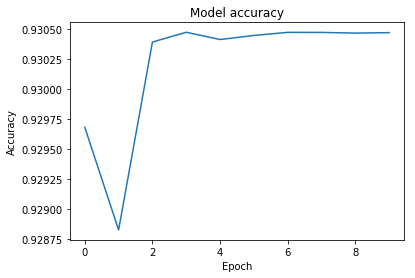

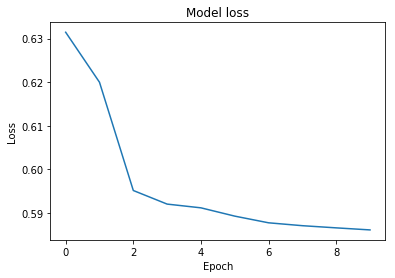

In [6]:
plot_history(history)

In [7]:
from keras.models import load_model
import json
model = load_model('baseline_bidirec.h5')

C:\Users\vinit\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
predictions = np.argmax(model.predict(X_val), axis=2) ##Greedy Search Decoder

In [15]:
show_generated_responses(X_val, y_val, predictions, y_idx_to_word_full)

Utterance :as in

Actual res:his schwanzstucker

genera res:i

Utterance :as depp

Actual res:whew a nineteen inch drill

genera res:i

Utterance :but working going actually you use smythe

Actual res:do you know the theme from 'doctor zhivago'

genera res:i

Utterance :do wrong movie

Actual res:why don't we all turn in it's been a long day

genera res:i

Utterance :take that's each 'em come

Actual res:you can't expect to iron out all the kinks in one night

genera res:i

Utterance :you tell air to competition out are the julie'll me right better

Actual res:i think the doctor is a genius don't you igor

genera res:i

Utterance :i think the actually is a tests for you prescott

Actual res:why certainly don't you frau blucher

genera res:i

Utterance :that's i'm you this into girl

Actual res:the doctor said to allow seven minutes no more and no less or else they could both become hopelessly paralyzed

genera res:i

Utterance :that's doing is it you're each

Actual res:four

genera re

In [20]:
prediction = model.predict(X_val)
np.argsort(prediction[0], axis=1)

array([[44637, 18454, 44225, ...,    20,     1,     2],
       [15033, 25271, 28704, ...,     2,     1,     0],
       [18956, 35929, 19879, ...,     2,     1,     0],
       ...,
       [ 1203,  1496,  1960, ...,     2,    20,     0],
       [ 1203,  1496,  1960, ...,     2,    20,     0],
       [ 1203,  1496,  1163, ...,     2,    20,     0]], dtype=int64)

In [ ]:
Lets try pretrained embeddings 

Some improvements to baseline -

1) The vocabulary sizes(i.e the whole dataset, we are using a small sample here for the dry run) are too large to use full softmax(this makes training super slow); sampled softmax, an approximation of softmax needs to be used

2) Try bidirectional GRUs  --done 

3) Introduce Attention mechanism 

4) Try Truncated BackPropogation through time if gradient-clipping, weight regularization alone are not helping "frozen" training (which is presumably due to gradient explosion, I was not able to retrieve logs from IBM Watson Studio)

5) Use Beam-search decoder instead of Greedy-Search for more accuracy.

6) Avoid too much padding that leads to extraneous computation instead use Bucketing

This means I need to switch to Tensorflow for more flexibility especially for Sampled Softmax is not implemented in Keras ( looks like some kind of a hacky work-around exists 
https://stackoverflow.com/questions/47892380/how-can-i-use-tensorflows-sampled-softmax-loss-function-in-a-keras-model)

In [192]:
print(tf.__version__)

1.4.0


# New heading